#### Import necessary libraries

In [61]:
import torch
from torch import nn, optim
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from colorama import Fore, Style

#### Load Data

In [36]:
train_data = fetch_20newsgroups(
    data_home='data/',
    subset='train',
    shuffle=True
)

test_data = fetch_20newsgroups(
    data_home='data/',
    subset='test',
    shuffle=False
)

X_train, X_test, y_train, y_test = train_data.data, test_data.data, train_data.target, test_data.target

#### Prepare Data

In [37]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

In [38]:
print(f'X_train shape: {X_train_vectorized.shape}\nX_test shape: {X_test_vectorized.shape}')

X_train shape: (11314, 10000)
X_test shape: (7532, 10000)


In [39]:
X_train_torch = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
X_test_torch = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [40]:
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [41]:
batch_idx, (data, targets) = next(enumerate(test_loader))

print(f'Batch data shape: {data.shape}')
print(f'Target for batch is: {targets}')

Batch data shape: torch.Size([64, 10000])
Target for batch is: tensor([10, 16, 14, 18,  5,  7,  2,  7,  1,  1,  1,  1, 13, 15,  3, 14,  4, 10,
        15,  2, 10, 15,  5, 13, 18, 15,  9,  0, 13,  8, 19,  3,  1, 18, 17, 18,
         9,  4,  3,  9,  9,  5, 17, 14, 16,  5,  8,  4, 16, 17, 12, 17, 13, 10,
         0, 19,  7,  0,  5,  7,  5, 14, 14,  0])


#### Build Model and Hyperparameters

In [42]:
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
            )
    
    def forward(self, x):
        return self.sequential(x)

In [81]:
model = TextClassifier(10000, 500, 20)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
model

TextClassifier(
  (sequential): Sequential(
    (0): Linear(in_features=10000, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=20, bias=True)
  )
)

#### Define Helper Functions

In [82]:
def accuracy_fn(y_pred, y):
    correct = torch.eq(y_pred, y).sum().item()
    return correct * 100. / len(y)

def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn):
    total_loss, total_acc = 0, 0
    model.train()
    for batch_idx, (X, y) in enumerate(data_loader):
        y_logits = model(X)
        y_pred = torch.argmax(torch.sigmoid(y_logits), dim=1)
        loss = loss_fn(y_logits, y)
        acc = accuracy_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc
    total_loss /= len(data_loader)
    total_acc /= len(data_loader)
    return total_loss, total_acc

def test_step(model, data_loader, loss_fn, accuracy_fn):
    total_loss, total_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_logits = model(X)
            y_pred = torch.argmax(torch.sigmoid(y_logits), dim=1)
            loss = loss_fn(y_logits, y)
            acc = accuracy_fn(y_pred, y)
            total_loss += loss.item()
            total_acc += acc
    total_loss /= len(data_loader)
    total_acc /= len(data_loader)
    return total_loss, total_acc

def eval_mode(model, data_loader, loss_fn, accuracy_fn):
    total_loss, total_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_logits = model(X)
            y_pred = torch.argmax(torch.sigmoid(y_logits), dim=1)
            loss = loss_fn(y_logits, y)
            acc = accuracy_fn(y_pred, y)
            total_loss += loss.item()
            total_acc += acc
    total_loss /= len(data_loader)
    total_acc /= len(data_loader)
    results = {
        'model_name': model.__class__.__name__,
        'model_loss': total_loss,
        'model_acc': total_acc
    }
    return results

In [83]:
train_losses, train_accs, test_losses, test_accs = [], [], [], []
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, accuracy_fn)
    test_loss, test_acc = test_step(model, test_loader, loss_fn, accuracy_fn)
    print(f'Epoch: {epoch} | Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
print('Final result:')
model_results = eval_mode(model, test_loader, loss_fn, accuracy_fn)
print(model_results)

Epoch: 0 | Train loss: 2.93867, Train acc: 28.08% | Test loss: 2.77631, Test acc: 45.84%
Epoch: 1 | Train loss: 2.13684, Train acc: 61.38% | Test loss: 1.70147, Test acc: 68.51%
Epoch: 2 | Train loss: 1.16460, Train acc: 81.65% | Test loss: 1.14725, Test acc: 74.56%
Epoch: 3 | Train loss: 0.70461, Train acc: 88.27% | Test loss: 0.89383, Test acc: 78.01%
Epoch: 4 | Train loss: 0.46169, Train acc: 92.20% | Test loss: 0.76221, Test acc: 79.55%
Epoch: 5 | Train loss: 0.31831, Train acc: 94.84% | Test loss: 0.68689, Test acc: 80.23%
Epoch: 6 | Train loss: 0.22716, Train acc: 96.44% | Test loss: 0.64786, Test acc: 81.07%
Epoch: 7 | Train loss: 0.16560, Train acc: 97.76% | Test loss: 0.62771, Test acc: 81.42%
Epoch: 8 | Train loss: 0.12266, Train acc: 98.51% | Test loss: 0.61089, Test acc: 81.69%
Epoch: 9 | Train loss: 0.09190, Train acc: 99.04% | Test loss: 0.60829, Test acc: 81.81%
Final result:
{'model_name': 'TextClassifier', 'model_loss': 0.6082908157574929, 'model_acc': 81.8121629429892

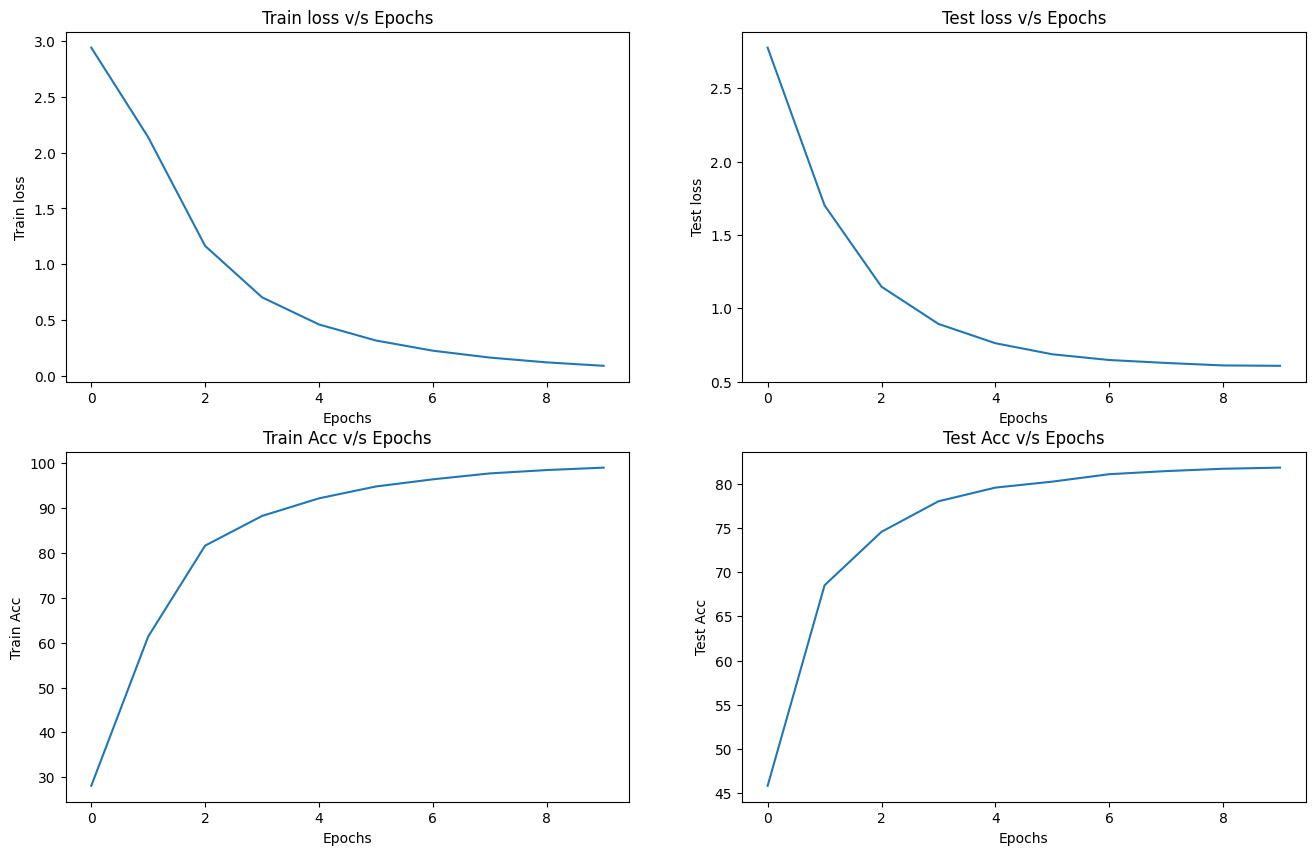

In [84]:
#### Plot loss and accuracy curves
epoch_counts = [i for i in range(epochs)]

plt.figure(figsize=(16, 10))
# Train loss curve
plt.subplot(2, 2, 1)
plt.plot(epoch_counts, train_losses)
plt.xlabel('Epochs')
plt.ylabel('Train loss')
plt.title('Train loss v/s Epochs')

# Test loss curve
plt.subplot(2, 2, 2)
plt.plot(epoch_counts, test_losses)
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.title('Test loss v/s Epochs')

# Train acc curve
plt.subplot(2, 2, 3)
plt.plot(epoch_counts, train_accs)
plt.xlabel('Epochs')
plt.ylabel('Train Acc')
plt.title('Train Acc v/s Epochs')

# Test acc curve
plt.subplot(2, 2, 4)
plt.plot(epoch_counts, test_accs)
plt.xlabel('Epochs')
plt.ylabel('Test Acc')
plt.title('Test Acc v/s Epochs')
plt.show()

In [85]:
batch_idx, (batch_data, batch_targets) = next(enumerate(test_loader))
model.eval()
with torch.inference_mode():
    output = model(batch_data)
    prediction = torch.argmax(torch.sigmoid(output), dim=1)

In [86]:
class_names = train_data.target_names

In [89]:
for i in range(10):
    single_label = batch_targets[i]
    single_prediction = prediction[i]
    if single_label == single_prediction:
        print(f'Label: {single_label} | ' + Fore.GREEN + f'Prediction: {single_prediction}')  
    else:
        print(f'Label: {single_label} | ' + Fore.RED + f'Prediction: {single_prediction}')
    print(Style.RESET_ALL)

Label: 10 | Prediction: 10

Label: 16 | Prediction: 16

Label: 14 | Prediction: 1

Label: 18 | Prediction: 18

Label: 5 | Prediction: 5

Label: 7 | Prediction: 7

Label: 2 | Prediction: 1

Label: 7 | Prediction: 7

Label: 1 | Prediction: 1

Label: 1 | Prediction: 1

